# Find Spectrograms for syllable_df
### JX, 10/12/22
> Get specs

In [1]:
from starling_rhythm.utils.paths import PROCESSED_DIR

## Import dataframes

In [2]:
import pandas as pd

In [3]:
SAVE_PATH = PROCESSED_DIR / 'starling_b1555_amp_envs200.pickle'
ae_df = pd.read_pickle(SAVE_PATH).reset_index()

In [4]:
SAVE_PATH = PROCESSED_DIR / 'starling_b1555_syllable_df.pickle'
syllable_df = pd.read_pickle(SAVE_PATH)

## Get row audio

In [5]:
from starling_rhythm.utils.audio import int16_to_float32
from tqdm.autonotebook import tqdm
import numpy as np

/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
rate = 48000

In [7]:
syl_audio = []
rates = []

for syllable in tqdm(syllable_df.iterrows(), desc = 'retrieving audio for all syllables'):
    
    ## differentiate
    index = syllable[0]
    syllable_info = syllable[1]
    
    ## for each syllable, load in the waveform corresponding to the bout index
    waveform = ae_df.loc[syllable_info.ae_df_index].waveform
    
    ## slice out 
    strt = int(syllable_info.onsets_ms * rate)
    end = int(syllable_info.offsets_ms * rate)
    syl_audio.append(waveform[strt:end])
    rates.append(rate)

retrieving audio for all syllables: 53757it [00:17, 3140.17it/s]


In [8]:
syllable_df['audio'] = syl_audio
syllable_df['audio'] = [i/np.max(i) for i in syllable_df['audio'].values] ## normalize

In [9]:
syllable_df['rate'] = rates

## Create Spectrograms

In [10]:
from avgn.utils.hparams import HParams
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [11]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [12]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -45,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 0,
) ## from Tim

In [13]:
from joblib import Parallel, delayed
n_jobs = 36
verbosity = 0

In [14]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=hparams,
            mel_matrix=prepare_mel_matrix(hparams, rate),
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

getting syllable spectrograms:   0%|          | 0/53757 [00:00<?, ?it/s]2022-10-13 11:06:45.548500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 11:06:45.548558: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-13 11:06:45.592736: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 11:06:46.639485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-13 11:06:46.639625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynam

## Rescale spectrograms 

In [15]:
log_scaling_factor = 4

In [16]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

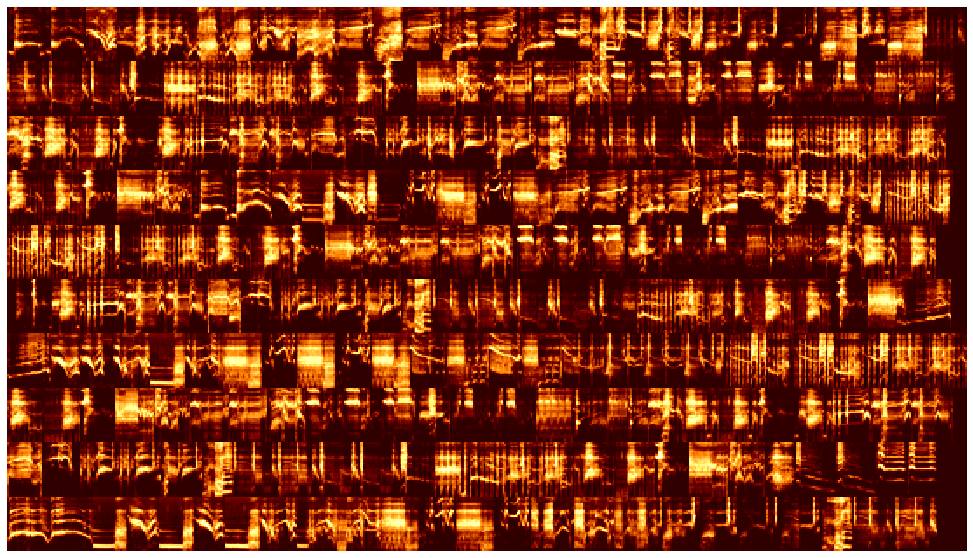

In [17]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

## Pad spectrograms

In [18]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [19]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

In [20]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]
# convert to uint8 to save space
syllable_df['spectrogram'] = syllables_spec

100%|██████████| 53757/53757 [00:03<00:00, 15241.46it/s]


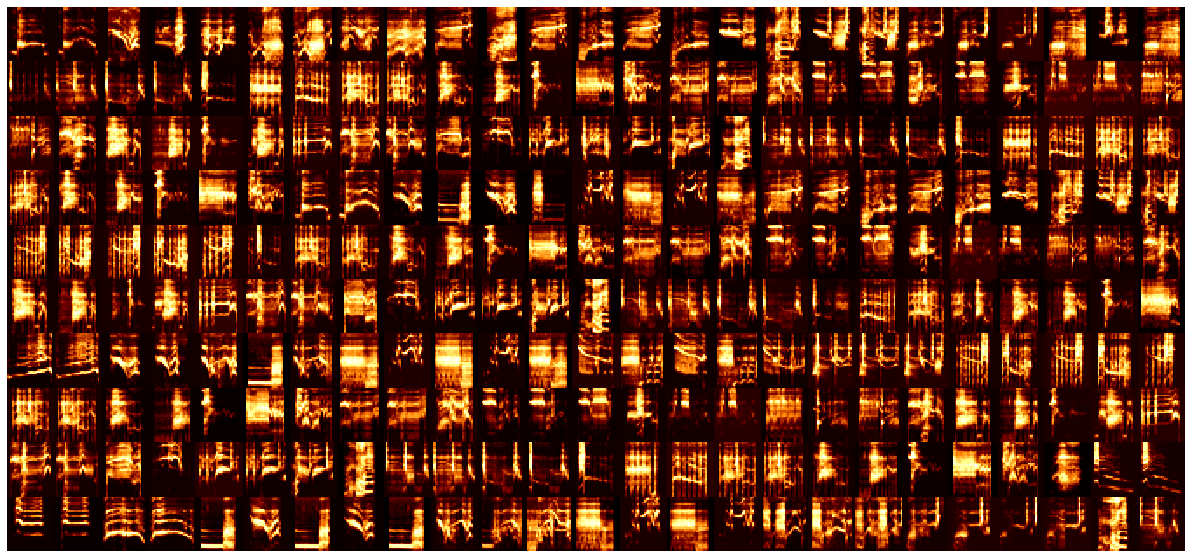

In [24]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [25]:
syllable_df.head()

,ae_df_index,indv,start_ms,end_ms,file,onsets_ms,offsets_ms,audio,rate,spectrogram
0,0,b1555,508500,566065,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,6.564,7.172,"[0.0053705692803437165, 0.0053705692803437165,...",48000,"[[8, 8, 8, 8, 7, 10, 13, 7, 8, 8, 8, 8, 8, 8, ..."
1,0,b1555,508500,566065,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,8.712,9.454,"[-0.002697841726618705, -0.0035971223021582736...",48000,"[[9, 9, 9, 8, 12, 18, 7, 9, 9, 9, 9, 9, 9, 9, ..."
2,0,b1555,508500,566065,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,9.461,9.663,"[-0.10294117647058823, -0.07352941176470588, -...",48000,"[[8, 8, 8, 8, 91, 54, 18, 16, 12, 17, 13, 84, ..."
3,0,b1555,508500,566065,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,11.317,11.505,"[-0.043343653250773995, -0.04953560371517028, ...",48000,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
4,0,b1555,508500,566065,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,11.508,11.820,"[0.011627906976744186, 0.007751937984496124, 0...",48000,"[[8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8,..."


## Pickle dataframe

In [21]:
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir

In [22]:
SAVE_PATH = PROCESSED_DIR / 'starling_b1555_syllable_df_spec_aud.pickle'
ensure_dir(SAVE_PATH)

In [23]:
syllable_df.to_pickle(SAVE_PATH)